In [426]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scienceplots
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit
from VisionTransformer_working_for_DPT import VisionTransformer3 as Vit3

In [427]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [428]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Load models

In [429]:
vit = Vit(dspl_size=104, 
          patch_size=8, 
          embed_dim=128,
          depth=4,
          n_heads=4,
          mlp_ratio=1.0,
          qkv_bias=False,
          p=0.1,
          attn_p=0.1,
          drop_path=0.).float()

path_to_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-final_2023-May-16 19:56:24/ViT-final_2023-May-16 19:56:24.pth'

vit.load_state_dict(torch.load(path_to_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [430]:
prob_vit = Vit3(dspl_size=104, 
                patch_size=8, 
                embed_dim=128,
                depth=4,
                n_heads=4,
                mlp_ratio=1.0,
                qkv_bias=False,
                p=0.1,
                attn_p=0.1,
                drop_path=0.).float()

path_to_prob_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-GNLL_final2023-May-17 23:02:08/ViT-GNLL_final2023-May-17 23:02:08.pth'

prob_vit.load_state_dict(torch.load(path_to_prob_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [431]:
# cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy-2023-Mar-21 18:13:25_checkpoint.h5')
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy_final-2023-May-18 23:46:36_checkpoint.h5')

## Load data

In [432]:
real_cells = []
real_dspl = torch.zeros((14, 2, 104, 104))
directory = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'

for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        real_cell = {}
        file = loadmat(directory+'/'+filename)
        real_cell['brdx'] = np.rot90(file['brdx'], 2)
        real_cell['brdy'] = np.rot90(file['brdy'], 2)
        real_cell['dspl'] = torch.tensor((1 / 200.2) * np.transpose(file['dspl']))
        real_cell['vit_pred'] = vit(real_cell['dspl'].unsqueeze(0).float()) * 10670
        real_cell['prob_vit_pred'] = prob_vit(real_cell['dspl'].unsqueeze(0).float()) * 10670
        real_cell['cnn_pred'] = cnn.predict(np.expand_dims(np.moveaxis(np.array(real_cell['dspl']), 0, 2), 0)) * 10670
        real_cells.append(real_cell)

1/1 [==============================] - 0s 17ms/step


In [433]:
Bay_FTTC_results = loadmat('/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/real_cells/Samples/Bay-FTTC_results_24-05-23.mat')
TFM_results = Bay_FTTC_results['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
TFM_results[:, 0:3, :] = 0
TFM_results[:, :, 0:3] = 0
TFM_results[:, 99:, :] = 0
TFM_results[:, :, 99:] = 0
TFM_results_padded = F.pad(input=torch.tensor(TFM_results).float(), pad=(1, 1, 1, 1), mode='constant', value=0)

<IPython.core.display.Javascript object>


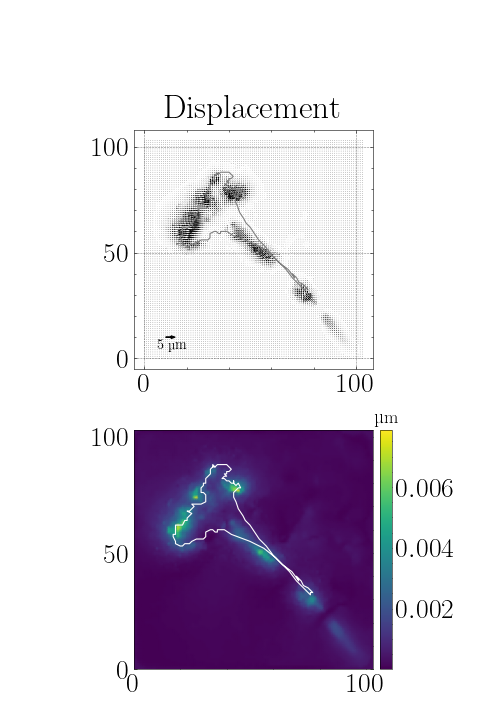

In [435]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0

#C = np.sqrt(real_cells[i]['dspl'][0, :, :].detach().numpy() ** 2 + real_cells[i]['dspl'][1, :, :].detach().numpy() ** 2)
#argmax = np.unravel_index(np.argmax(C, axis=None), C.shape)
#real_cells[i]['dspl'][0, 10, 10] = np.linalg.norm(C[argmax])
#real_cells[i]['dspl'][1, 10, 10] = 0

axs[0].quiver(real_cells[i]['dspl'][0, :, :].detach().numpy(), real_cells[i]['dspl'][1, :, :].detach().numpy(), scale=1/5)
axs[0].set(adjustable='box', aspect='equal')

axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')
axs[0].set_title('Displacement', pad=10, fontsize=30)
#axs[0].text(80, 110, 'Displacement', fontsize=35)
dx = 5 * 0.51948
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1.3, color='black')
axs[0].annotate(u'5 \xb5m',
                fontsize=13,
                xy=(0.1, 0.1), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(real_cells[i]['dspl'][0, :, :].detach().numpy() ** 2 + real_cells[i]['dspl'][1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud')
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
#axs[1].set_title(r'Displacement', pad=10, fontsize=35)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02)
colorbar.ax.set_title(u'\xb5m', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')
#cb_ax = fig.add_axes([.91,.124,.04,.754])
#fig.colorbar(im,orientation='vertical',cax=cb_ax)

fig.subplots_adjust(top=0.82)

image_name = 'Real_dspl_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

In [436]:
norm = matplotlib.colors.Normalize(vmin=0.0,vmax=np.max(np.sqrt(TFM_results_padded[0, :, :].detach().numpy() ** 2 + TFM_results_padded[1, :, :].detach().numpy() ** 2)))

<IPython.core.display.Javascript object>


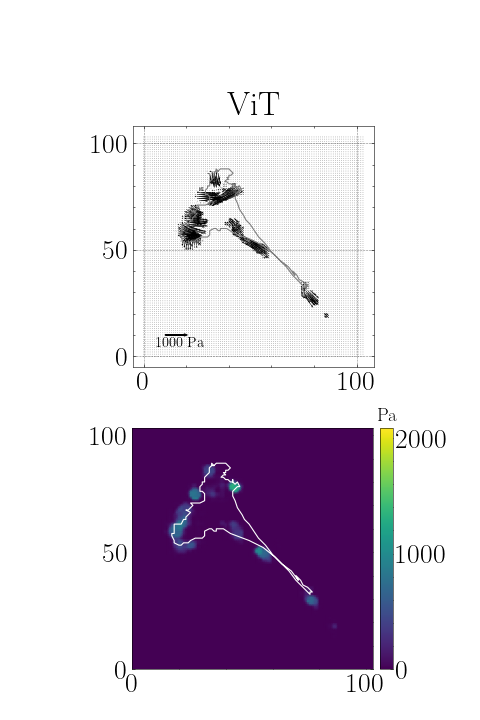

In [441]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0
axs[0].quiver(real_cells[i]['vit_pred'][0, 0, :, :].detach().numpy(), real_cells[i]['vit_pred'][0, 1, :, :].detach().numpy(), scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('ViT', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(real_cells[i]['vit_pred'][0, 0, :, :].detach().numpy() ** 2 + real_cells[i]['vit_pred'][0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_vit_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


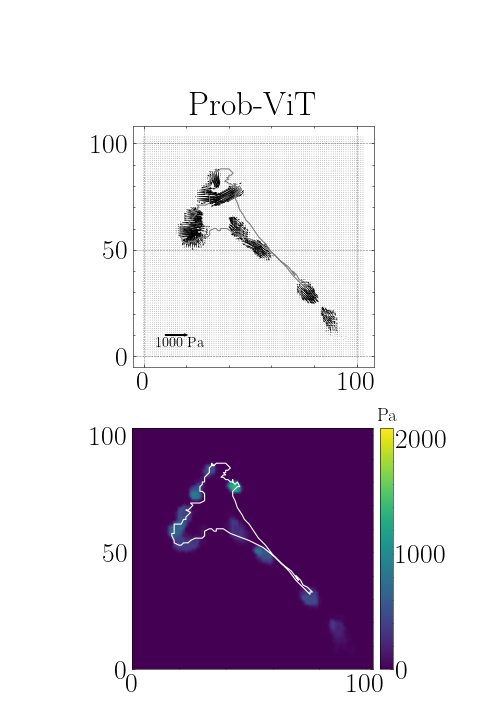

In [442]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0
axs[0].quiver(real_cells[i]['prob_vit_pred'][0, 0, :, :].detach().numpy(), real_cells[i]['prob_vit_pred'][0, 1, :, :].detach().numpy()  , scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('Prob-ViT', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(real_cells[i]['prob_vit_pred'][0, 0, :, :].detach().numpy() ** 2 + real_cells[i]['prob_vit_pred'][0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_prob-vit_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


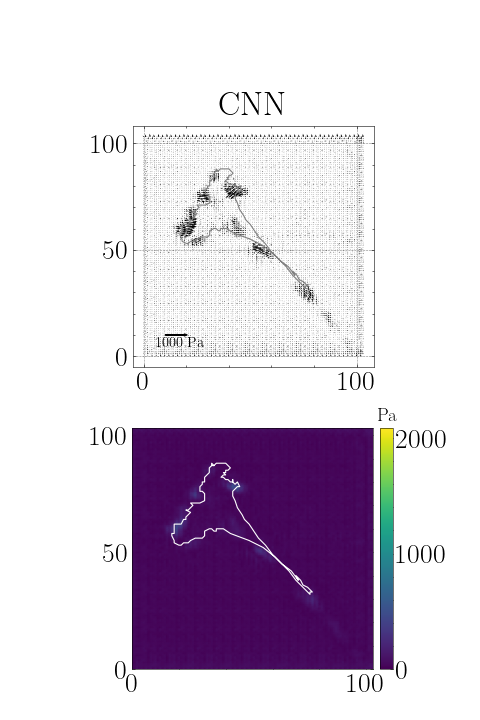

In [443]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0
axs[0].quiver(real_cells[i]['cnn_pred'][0, :, :, 0], real_cells[i]['cnn_pred'][0, :, :, 1], scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('CNN', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(real_cells[i]['cnn_pred'][0, :, :, 0] ** 2 + real_cells[i]['cnn_pred'][0, :, :, 1] ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_cnn_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


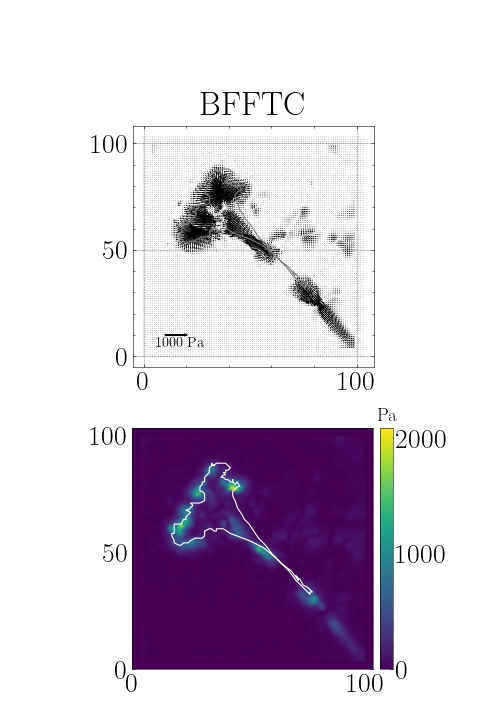

In [444]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0
axs[0].quiver(TFM_results_padded[0, :, :].detach().numpy().T, TFM_results_padded[1, :, :].detach().numpy().T, scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('BFFTC', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(TFM_results_padded[0, :, :].detach().numpy().T ** 2 + TFM_results_padded[1, :, :].detach().numpy().T ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_bfftc_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

scale conversion:
1 model pixel = 7 camera pixel, 
104mp = 7 * 104 * 0.275 micrometer = 200.2 micrometer = 0.2002 mm